<a href="https://colab.research.google.com/github/plaban1981/Deep-Learning-KERAS/blob/master/Detect_Covid_19_through_X_ray_images_of_Patients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

About the data

The training dataset contains X-ray and CT scan images of patients with positive Corona test and negative Corona test. 

* Dataset Link: https://drive.google.com/file/d/1BFc2Lt2N1swO8BKRvLMEyUhLzF52RFvr/view?usp=sharing

From the above link you will be able to download a zip file named ‘covid_image_data.zip’. After you extract this zip file, you will get four files:

* train - contains all the x-ray images of covid and non-covid patient that are to be used for training your model.  Each image has a unique name.
* Training_set_covid.csv - this csv file contains all the image ids present in the train folder with their respective label of ‘COVID’ i.e. 1 or ‘Non-COVID’ i.e. 0
* test - contains X-ray and CT scan images of covid and non-covid patient. For these images you are required to make predictions as ‘COVID’ i.e. 1 or ‘Non-COVID’ i.e. 0.
*Testing_set_covid.csv - this is the order of the predictions for each image that is to be submitted on the platform. Make sure the predictions you download are with their image’s filename and in the same order as given in this file.

* sample_submission: This is a csv file that contains the sample submission for the data sprint.


In [1]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1BFc2Lt2N1swO8BKRvLMEyUhLzF52RFvr',
dest_path='content/covid_image_data.zip',unzip=True)

Unzipping...Done.


# Import Libraries

In [2]:
import pandas as pd # Data analysis and manipultion tool
import numpy as np # Fundamental package for linear algebra and multidimensional arrays
import tensorflow as tf # Deep Learning Tool
#fast ai
from fastai import *
from fastai.vision import *
import os # OS module in Python provides a way of using operating system dependent functionality
import cv2 # Library for image processing
from sklearn.model_selection import train_test_split # For splitting the data into train and validation set
from sklearn.metrics import f1_score
from PIL import Image

# ignore Warnings

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
train = pd.read_csv("/content/content/covid_image_data/Training_set_covid.csv")
train.head()

,filename,label
0,Image_1.jpg,1
1,Image_2.jpg,0
2,Image_3.jpg,0
3,Image_4.jpg,0
4,Image_5.jpg,0


In [5]:
test = pd.read_csv("/content/content/covid_image_data/Testing_set_covid.csv")
test.head()

,filename
0,Image_1.jpg
1,Image_2.jpg
2,Image_3.jpg
3,Image_4.jpg
4,Image_5.jpg


In [11]:
!mkdir "/content/Data"
!mkdir "/content/Data/Covid"

In [12]:
!mkdir "/content/Data/Covid/Train"
!mkdir "/content/Data/Covid/Val"

In [14]:
!mkdir "/content/Data/Covid/Train/Non_Covid"
!mkdir "/content/Data/Covid/Train/Covid"
!mkdir "/content/Data/Covid/Val/Non_Covid"
!mkdir "/content/Data/Covid/Val/Covid"

mkdir: cannot create directory ‘/content/Data/Covid/Train/Non_Covid’: File exists
mkdir: cannot create directory ‘/content/Data/Covid/Train/Covid’: File exists
mkdir: cannot create directory ‘/content/Data/Covid/Val/Non_Covid’: File exists
mkdir: cannot create directory ‘/content/Data/Covid/Val/Covid’: File exists


In [15]:
train.shape,test.shape

((3479, 2), (870, 1))

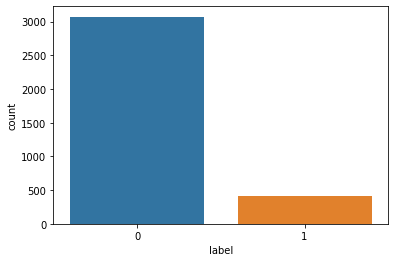

In [ ]:
import seaborn as sns 
sns.countplot(train.label)

In [9]:
X_train,X_test = train_test_split(train,test_size=0.2,stratify= train['label'],random_state=42)

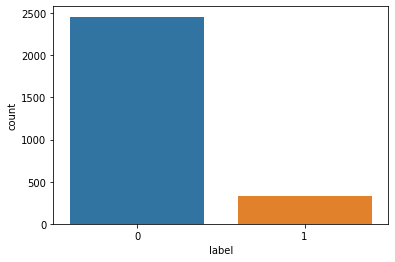

In [ ]:
sns.countplot(X_train.label)

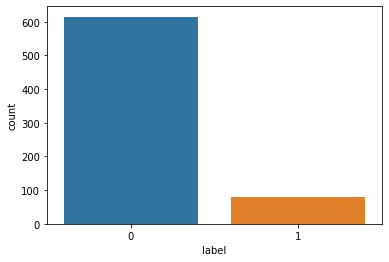

In [ ]:
sns.countplot(X_test.label)

In [16]:
import shutil
train_img_path = "/content/content/covid_image_data/train"
train_non_covid_path = "/content/Data/Covid/Train/Non_Covid"
train_covid_path = "/content/Data/Covid/Train/Covid"
val_non_covid_path = "/content/Data/Covid/Val/Non_Covid"
val_covid_path = "/content/Data/Covid/Val/Covid"

In [17]:
import PIL

#### Moving images to corresponding folders - Train

In [18]:
for index,row in X_train.iterrows():
  image_path = train_img_path + "/"+row['filename']
  #
  if row['label'] == 0:
    shutil.move(image_path,train_non_covid_path)
  else:
    shutil.move(image_path,train_covid_path)

#### Moving images to corresponding folders - Val

In [19]:
for index,row in X_test.iterrows():
  image_path = train_img_path + "/"+row['filename']
  #
  if row['label'] == 0:
    shutil.move(image_path,val_non_covid_path )
  else:
    shutil.move(image_path,val_covid_path )


In [20]:
len([img for img in os.listdir("/content/Data/Covid/Train/Covid")]) + len([img for img in os.listdir("/content/Data/Covid/Val/Covid")])

406

In [21]:
train[train.label == 1].shape

(406, 2)

#### **Use Fastai**

In [ ]:
path = '/content/Data'
data = ImageDataBunch.from_folder(path,train='Train',valid='val',test='Test',ds_tfms=get_transforms(),size=224).normalize(imagenet_stats)

In [ ]:
print(f' total number of classes {data.c}')
print(f'class label : {data.classes}')

 total number of classes 2
class label : ['0_Non_Covid', '1_Covid']


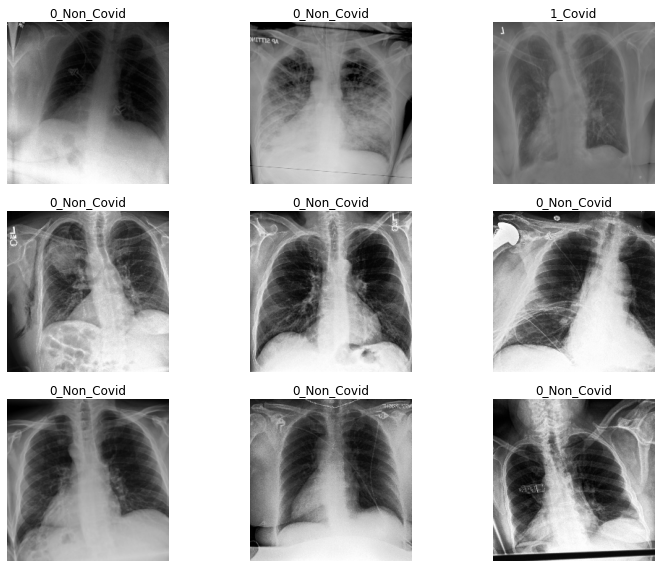

In [ ]:
data.show_batch(rows=3,figsize=(11,8))

In [ ]:
learn = create_cnn(data,models.resnet34,metrics=error_rate,model_dir='/content')
learn.lr_find()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


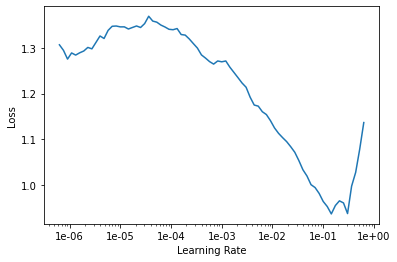

In [ ]:
learn.recorder.plot()

In [ ]:
lrs = slice(1e-3,1e-1)
learn.fit_one_cycle(5,lrs)

epoch,train_loss,valid_loss,error_rate,time
0,0.629525,1.218258,0.103448,01:01
1,0.667101,0.452706,0.091954,01:01
2,0.441441,0.172258,0.057471,00:59
3,0.300212,0.102149,0.045977,00:59
4,0.196611,0.100336,0.048851,00:59


## Keras

# Image Augmentor

In [22]:
pip install Augmentor

In [23]:
import Augmentor
# Build a new pipeline for image processing.

def imageAugmentation(source,output,num_samples):
  p = Augmentor.Pipeline(
      source_directory=source,
      output_directory=output)

  # Manipulate the example card.
  p.rotate_without_crop(
    probability=.5,
    max_left_rotation=10,
    max_right_rotation=10,
    expand=True)
  p.zoom(
    probability=.3,
    min_factor=.8,
    max_factor=1.1)
  p.skew(
    probability=.3,
    magnitude=.15)
  p.random_brightness(
    probability=.5,
    min_factor=.5,
    max_factor=1.75)

  # Generate and save 100 new images to the output directory.
  p.sample(num_samples)

### Augment Training covid images

In [24]:
imageAugmentation("/content/Data/Covid/Train/Covid","/content/Data/Covid/Train/Covid",200)

Executing Pipeline:   0%|          | 0/200 [00:00<?, ? Samples/s]

Initialised with 325 image(s) found.
Output directory set to /content/Data/Covid/Train/Covid.

Processing <PIL.Image.Image image mode=RGB size=1292x1176 at 0x7F2D80056780>: 100%|██████████| 200/200 [00:53<00:00,  3.77 Samples/s]


Augment Training non covid images

In [25]:
imageAugmentation("/content/Data/Covid/Train/Non_Covid","/content/Data/Covid/Train/Non_Covid",50)

Executing Pipeline:   0%|          | 0/50 [00:00<?, ? Samples/s]

Initialised with 2458 image(s) found.
Output directory set to /content/Data/Covid/Train/Non_Covid.

Processing <PIL.Image.Image image mode=RGB size=391x346 at 0x7F2D80016550>: 100%|██████████| 50/50 [00:01<00:00, 33.08 Samples/s]


Augment validation non covid images

In [ ]:
imageAugmentation("/content/Data/Covid/Val/Non_Covid","/content/Data/Covid/Val/Non_Covid",100)

Processing <PIL.Image.Image image mode=RGB size=428x366 at 0x7F05565909B0>:   6%|▌         | 6/100 [00:00<00:03, 31.10 Samples/s]

Initialised with 615 image(s) found.
Output directory set to /content/Data/Covid/Val/Non_Covid.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=320x333 at 0x7F0550C9BEB8>: 100%|██████████| 100/100 [00:01<00:00, 54.67 Samples/s]


Augment validation covid images

In [ ]:
imageAugmentation("/content/Data/Covid/Val/Covid","/content/Data/Covid/Val/Covid",100)

Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 81 image(s) found.
Output directory set to /content/Data/Covid/Val/Covid.

Processing <PIL.Image.Image image mode=RGB size=674x588 at 0x7F0552D02F60>: 100%|██████████| 100/100 [00:23<00:00,  4.22 Samples/s]


In [26]:
train_covid_path = "/content/Data/Covid/Train/Covid"
val_covid_path = "/content/Data/Covid/Val/Covid"
#
train_non_covid_path = "/content/Data/Covid/Train/Non_Covid"
val_non_covid_path = "/content/Data/Covid/Val/Non_Covid"

Text(0.5, 1.0, 'Original Image')

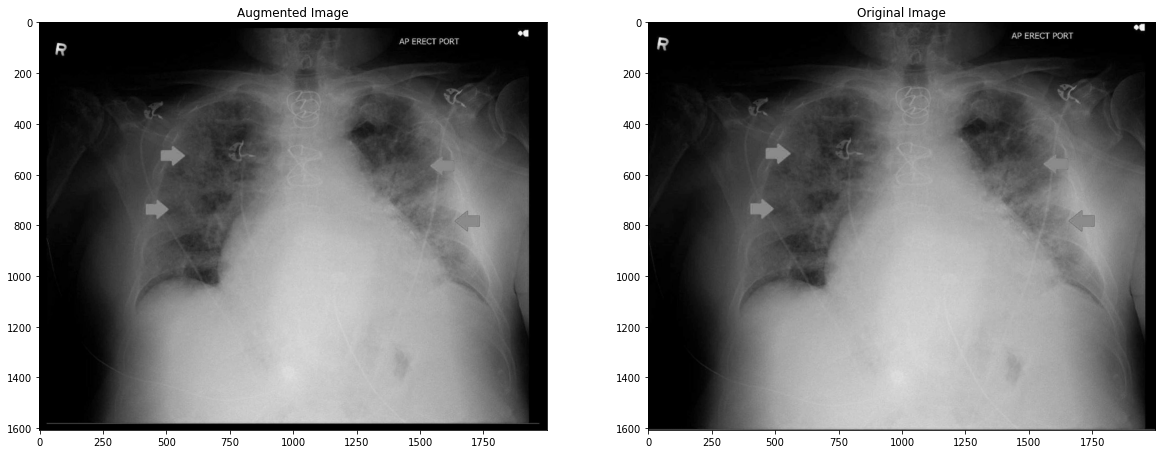

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize = (20, 12))
plt.subplot(1,2,1)
plt.imshow(PIL.Image.open("/content/Data/Covid/Train/Covid/Covid_original_Image_1029.jpg_8941f4b7-446f-4679-8f9f-12d19f12ccc4.jpg"))
plt.title('Augmented Image')
plt.subplot(1,2,2)
plt.imshow(PIL.Image.open("/content/Data/Covid/Train/Covid/Image_1029.jpg"))
plt.title('Original Image')

In [ ]:
image = cv2.imread("/content/Data/Covid/Train/Covid/Image_1264.jpg")
image.shape

(2000, 2000, 3)

In [29]:
train_dataset = []
train_labels = []
val_dataset = []
val_labels = []
test_dataset = []

## Function to convert images into array vectors

In [30]:
os.listdir("/content/Data/Covid/Train")

['Covid', 'Non_Covid']

In [31]:
def process_image(path_dir):
  dataset = []
  labels = []
  folder_images = os.listdir(path_dir)
  
  for folder in folder_images:
    print(folder)
    image_list = os.listdir(path_dir + "/"+folder+"/")
    #print(len(image_list))
    for images in image_list:
      #print(images)
      #print(path_dir+"/"+folder+"/" +images)
      image = cv2.imread(path_dir+"/"+folder+"/" +images)
      image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
      image = Image.fromarray(image)
      image = image.resize((224,224))
      dataset.append(np.array(image))
      if folder == 'Covid':
        labels.append(1)
      else:
        labels.append(0)
  return np.array(dataset),np.array(labels)


In [32]:
x_train,y_train = process_image("/content/Data/Covid/Train")

Covid
Non_Covid


In [33]:
type(x_train)

numpy.ndarray

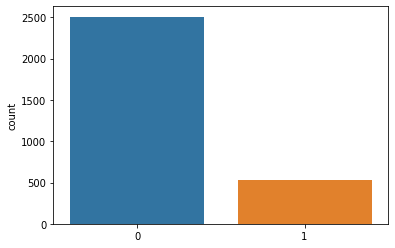

In [ ]:
sns.countplot(y_train)

In [34]:
train.shape

(3479, 2)

In [35]:
x_train.shape,y_train.shape

((3033, 224, 224), (3033,))

In [36]:
x_val,y_val = process_image("/content/Data/Covid/Val")

Covid
Non_Covid


In [37]:
x_val.shape,y_val.shape

((696, 224, 224), (696,))

Text(0.5, 1.0, 'LABEL 1')

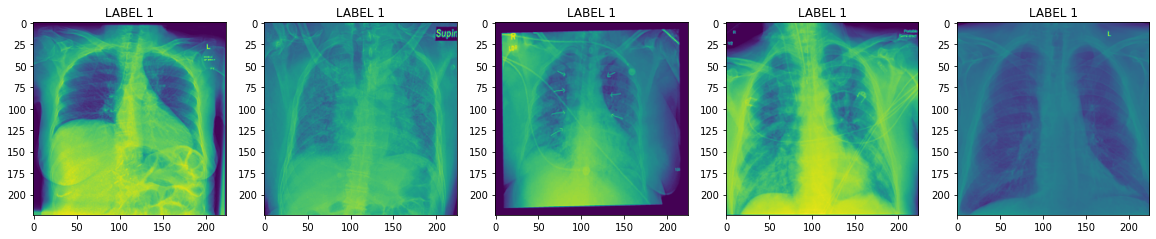

In [38]:
plt.figure(figsize = (20, 12))
plt.subplot(1,5,1)
plt.imshow(x_train[0])
plt.title('LABEL '+str(y_train[0]))
plt.subplot(1,5,2)
plt.imshow(x_train[100])
plt.title('LABEL '+str(y_train[100]))
plt.subplot(1,5,3)
plt.imshow(x_train[10])
plt.title('LABEL '+str(y_train[10]))
plt.subplot(1,5,4)
plt.imshow(x_train[20])
plt.title('LABEL '+str(y_train[20]))
plt.subplot(1,5,5)
plt.imshow(x_train[25])
plt.title('LABEL '+str(y_train[25]))

IndexError: ignored

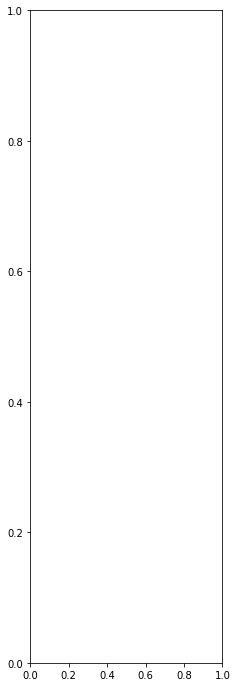

In [ ]:
plt.figure(figsize = (20, 12))
plt.subplot(1,5,1)
plt.imshow(test_dataset[0])
plt.subplot(1,5,2)
plt.imshow(test_dataset[100])
plt.subplot(1,5,3)
plt.imshow(test_dataset[10])
plt.subplot(1,5,4)
plt.imshow(test_dataset[20])
plt.subplot(1,5,5)
plt.imshow(test_dataset[25])

In [ ]:
# Defining the model
model = tf.keras.Sequential([
tf.keras.layers.Flatten(input_shape=(224, 224)), # flattening the image
tf.keras.layers.Dense(100, activation='relu'),
tf.keras.layers.Dense(50, activation='relu'),
tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
loss='binary_crossentropy',
metrics=['accuracy'])

model.fit(x_train, y_train, epochs=25, batch_size=128)

Epoch 1/25
25/25 [==============================] - 0s 6ms/step - loss: 1296.8099 - accuracy: 0.7201
Epoch 2/25
25/25 [==============================] - 0s 7ms/step - loss: 169.4596 - accuracy: 0.8359
Epoch 3/25
25/25 [==============================] - 0s 6ms/step - loss: 97.7968 - accuracy: 0.8803
Epoch 4/25
25/25 [==============================] - 0s 6ms/step - loss: 66.3600 - accuracy: 0.8855
Epoch 5/25
25/25 [==============================] - 0s 6ms/step - loss: 49.4236 - accuracy: 0.8628
Epoch 6/25
25/25 [==============================] - 0s 6ms/step - loss: 160.5866 - accuracy: 0.7898
Epoch 7/25
25/25 [==============================] - 0s 6ms/step - loss: 68.8577 - accuracy: 0.8852
Epoch 8/25
25/25 [==============================] - 0s 6ms/step - loss: 40.3697 - accuracy: 0.8988
Epoch 9/25
25/25 [==============================] - 0s 6ms/step - loss: 23.2385 - accuracy: 0.9004
Epoch 10/25
25/25 [==============================] - 0s 6ms/step - loss: 151.2872 - accuracy: 0.7804
Epoc

In [ ]:
pred = model.predict(x_val) # predict labels for validation set

y_pred = []
for item in pred:
  if item < 0.5:
    y_pred.append(0)
  else:
    y_pred.append(1)

In [ ]:
f1_score(y_val, y_pred)

0.7294685990338164

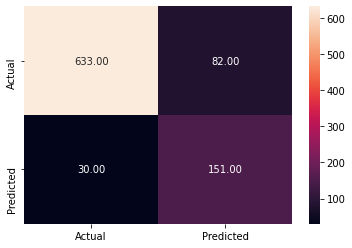

In [ ]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(y_val,y_pred)
sns.heatmap(cf,annot=True,fmt='.2f',xticklabels=['Actual','Predicted'],yticklabels=['Actual','Predicted'])

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_val,y_pred)

0.875

In [ ]:
test.head()

,filename
0,Image_1.jpg
1,Image_2.jpg
2,Image_3.jpg
3,Image_4.jpg
4,Image_5.jpg


# Process Test Image

In [ ]:
def process_test_image(path_dir):
  dataset = []
  image_list = os.listdir(path_dir)
    #print(len(image_list))
  for images in image_list:
      #print(images)
      #print(path_dir+"/"+folder+"/" +images)
      image = cv2.imread(path_dir+"/"+images)
      image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
      image = Image.fromarray(image)
      image = image.resize((224,224))
      dataset.append(np.array(image))
  return np.array(dataset)

In [ ]:
x_test =  process_test_image("/content/content/covid_image_data/test")

In [ ]:
x_test.shape

(870, 224, 224)

In [ ]:
preds = model.predict(x_test)
prediction = []
for value in preds:
  if value < 0.5:
     prediction.append(0)
  else:
    prediction.append(1)

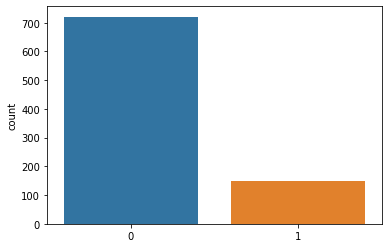

In [ ]:
sns.countplot(prediction)

In [ ]:
res = pd.DataFrame({'filename': test['filename'], 'prediction': prediction}) # prediction is nothing but the final predictions of your model on input features of your new unseen test data
res['prediction'].to_csv("submission2.csv", index = False)

# To download the csv file locally
from google.colab import files
files.download('submission2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [39]:
from keras.layers import Input,Dense,Flatten
from keras.layers import Dropout
from keras.layers import GlobalAveragePooling2D
from keras.layers import Convolution2D,Conv2D
from keras.layers import MaxPooling2D,MaxPool2D
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.models import Model
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.applications.nasnet import NASNetLarge
from keras.applications.resnet50 import ResNet50
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.optimizers import RMSprop,Adam
from glob import glob

In [ ]:
!rm -r  /content/Data/Test

In [ ]:
x_train.shape

(3083, 224, 224)

## Custome metrics

In [40]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
 # create model
 def classifier(IMG_SIZE):
    model = Sequential()
#     model.add(keras.Input(shape=(None, IMG_SIZE, IMG_SIZE, 1)))
#     Convolutional layer 1 with 32 filters of kernel size[5,5] 
    model.add(Conv2D(filters=32, kernel_size=(5, 5), 
                     strides=(1, 1), activation='relu', 
                     input_shape=(IMG_SIZE, IMG_SIZE, 1)))
#     Pooling layer 1 with pool size[2,2] and stride 2 
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
#     Convolutional layer 2 with 64 filters of kernel size[5,5] 
    model.add(Conv2D(64, (5, 5), strides=(1, 1), activation='relu'))
#  Pooling layer 2 with pool size[2,2] and stride 2 
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Flatten())
    
#     Dense layer whose output size is fixed in the hyper parameter: 
    model.add(Dense(units=64, activation='relu'))
    
#     Dropout layer with dropout probability 0.4 
    model.add(Dropout(0.3))
    #     Dense layer whose output size is fixed in the hyper parameter: 
    model.add(Dense(units=32, activation='relu'))
    
#     Dropout layer with dropout probability 0.4 
    model.add(Dropout(0.2))
    
#     units is 2 because we have 2 classes to predict 
    model.add(Dense(units=1, activation='sigmoid'))
    
    # Compile model
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # compile model
    model.compile(
             #optimizer=RMSprop(lr=0.001),
             optimizer=Adam(lr=0.0001),
             loss='binary_crossentropy',
             metrics=['accuracy',f1_m])
    return model

In [ ]:
model = classifier(224)

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 220, 220, 32)      832       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 106, 106, 64)      51264     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 53, 53, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 179776)            0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                11505728  
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)               

In [ ]:
 x_train = x_train.reshape(-1, 224, 224, 1)

In [ ]:
x_train.shape

(3033, 224, 224, 1)

In [ ]:
x_val.shape

(696, 224, 224)

In [ ]:
x_val = x_val.reshape(-1,224,224,1)

In [ ]:
history = model.fit(x_train, y_train, validation_data=(x_val,y_val), epochs=10, verbose=2)

Epoch 1/10
95/95 - 3s - loss: 3.5866 - accuracy: 0.8206 - f1_m: 0.3644 - val_loss: 0.2063 - val_accuracy: 0.9195 - val_f1_m: 0.0820
Epoch 2/10
95/95 - 2s - loss: 0.2494 - accuracy: 0.8671 - f1_m: 0.6048 - val_loss: 0.1865 - val_accuracy: 0.9282 - val_f1_m: 0.1030
Epoch 3/10
95/95 - 2s - loss: 0.2270 - accuracy: 0.8938 - f1_m: 0.6879 - val_loss: 0.2060 - val_accuracy: 0.9325 - val_f1_m: 0.0976
Epoch 4/10
95/95 - 2s - loss: 0.2231 - accuracy: 0.8975 - f1_m: 0.7009 - val_loss: 0.1665 - val_accuracy: 0.9181 - val_f1_m: 0.1012
Epoch 5/10
95/95 - 2s - loss: 0.1970 - accuracy: 0.9060 - f1_m: 0.6973 - val_loss: 0.1668 - val_accuracy: 0.9267 - val_f1_m: 0.1086
Epoch 6/10
95/95 - 2s - loss: 0.1824 - accuracy: 0.9136 - f1_m: 0.7337 - val_loss: 0.1707 - val_accuracy: 0.9353 - val_f1_m: 0.1055
Epoch 7/10
95/95 - 2s - loss: 0.1753 - accuracy: 0.9205 - f1_m: 0.7502 - val_loss: 0.1460 - val_accuracy: 0.9368 - val_f1_m: 0.1158
Epoch 8/10
95/95 - 2s - loss: 0.1633 - accuracy: 0.9301 - f1_m: 0.7861 - val

Training Accuracy vs Validation accuracy

Text(0, 0.5, 'Accuracy')

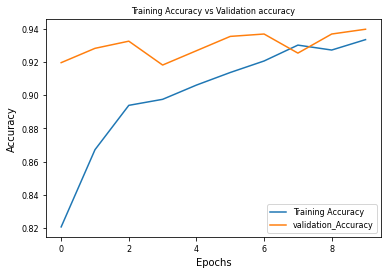

In [ ]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title



plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='validation_Accuracy')
plt.title('Training Accuracy vs Validation accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

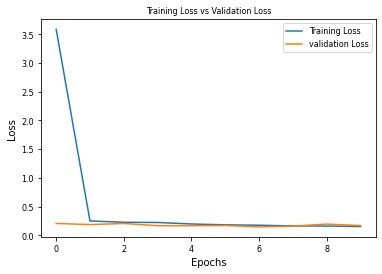

In [ ]:
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.legend()
plt.ylabel('Loss')

# Predictions

In [ ]:
preds = model.predict(x_val)
prediction = []
for value in preds:
  if value < 0.5:
     prediction.append(0)
  else:
    prediction.append(1)

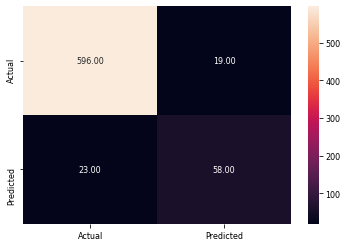

In [ ]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(y_val,prediction)
sns.heatmap(cf,annot=True,fmt=".2f",xticklabels=['Actual','Predicted'],yticklabels=['Actual','Predicted'])

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_val,prediction)

0.7341772151898733

# Process Test images for prediction

In [70]:
file_paths = [[fname, '/content/content/covid_image_data/test/' + fname] for fname in test['filename']]
if len(test) == len(file_paths):
  print('Number of image names i.e. ', len(test), 'matches the number of file paths i.e. ', len(file_paths))
else:
  print('Number of image names does not match the number of filepaths')

#
test_images = pd.DataFrame(file_paths, columns=['filename', 'filepaths'])
test_images.head()

Number of image names i.e.  870 matches the number of file paths i.e.  870


,filename,filepaths
0,Image_1.jpg,/content/content/covid_image_data/test/Image_1...
1,Image_2.jpg,/content/content/covid_image_data/test/Image_2...
2,Image_3.jpg,/content/content/covid_image_data/test/Image_3...
3,Image_4.jpg,/content/content/covid_image_data/test/Image_4...
4,Image_5.jpg,/content/content/covid_image_data/test/Image_5...


In [ ]:
test_pixel_data = [] # initialize an empty numpy array
image_size = 224 # image size taken is 100 here. one can take other size too
for i in range(len(test_images)):
  img_array = cv2.imread(test_images['filepaths'][i], cv2.IMREAD_GRAYSCALE) # converting the image to gray scale

  new_img_array = cv2.resize(img_array, (image_size, image_size)) # resizing the image array

  test_pixel_data.append(new_img_array)

#
test_pixel_data = np.array(test_pixel_data)
test_pixel_data = test_pixel_data.reshape(-1,224,224,1)
#
print(test_pixel_data.shape)
pred = model.predict(test_pixel_data)
prediction = []
for value in pred:
  if value < 0.5:
     prediction.append(0)
  else:
    prediction.append(1)

#
res = pd.DataFrame({'filename': test_images['filename'], 'prediction': prediction}) # prediction is nothing but the final predictions of your model on input features of your new unseen test data
res['prediction'].to_csv("submission_keras.csv", index = False)

# To download the csv file locally
from google.colab import files
files.download('submission_keras.csv')

(870, 224, 224, 1)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **Dphi Submission Scores :67.32673267326733**

##**Keras Tuner**

In [41]:
!pip install -U keras-tuner

     |████████████████████████████████| 71kB 6.8MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp36-none-any.whl size=78937 sha256=e757480e44ef3fc8216c3974f55d13688724251c985bdca83fd44fe0fb07a7fc
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=5bb8ede9f8c34afe7fecd29786e1a66a8484326bda15e791a7dc5c48cbc0dee0
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [42]:
from kerastuner import HyperModel, Objective
from kerastuner.tuners import BayesianOptimization
import tensorflow as tf
from kerastuner.tuners import RandomSearch
import kerastuner as kt

In [43]:
def build_model(hp):
  model = Sequential([Conv2D(filters=hp.Int('convolution_1',min_value=32, max_value=256, step=16), 
                          kernel_size=hp.Choice('convolution_1', values = [3,6]),
                          activation='relu',
                          input_shape=(224,224,1)),
                      MaxPool2D(pool_size=2),
                      Dropout(rate=hp.Float('dropout_2',min_value=0.0,max_value=0.5,step=0.05)),
                      Conv2D(filters=hp.Int('convolution_2', min_value=64, max_value=256, step=16),
                          kernel_size=hp.Choice('convolution_2', values = [3,6]),
                           activation='relu'),
                      MaxPool2D(pool_size=2),
                      Dropout(rate=hp.Float('dropout_2',min_value=0.0,max_value=0.5,step=0.05)),
                      Flatten(),
                      Dense(units=hp.Int('convolution_3', min_value=64, max_value=256, step=16),
                            activation ='relu'),
                      Dropout(rate=hp.Float('dropout_3',min_value=0.0,max_value=0.5,step=0.05)),
                      Dense(1,activation='sigmoid')
                       ])
  model.compile(optimizer=Adam(hp.Choice('learning_rate',values=[1e-2, 1e-3])),
                loss='binary_crossentropy',
                metrics=['accuracy'])
  return model
   

In [ ]:
!mkdir /content/tuner

mkdir: cannot create directory ‘/content/tuner’: File exists


In [ ]:
tuner_search=RandomSearch(build_model,
                       objective='val_accuracy',
                       max_trials=5,directory='/content/tuner',project_name="covid_classification")

# Searching for optimal hyperparameters. 

In [ ]:
tuner_search.search(x_train,y_train,epochs=5,validation_data=(x_val,y_val))


Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
convolution_1     |80                |?                 
dropout_2         |0.35              |?                 
convolution_2     |144               |?                 
convolution_3     |192               |?                 
dropout_3         |0.4               |?                 
learning_rate     |0.01              |?                 



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py", line 1812, in _create_c_op
    c_op = pywrap_tf_session.TF_FinishOperation(op_desc)
tensorflow.python.framework.errors_impl.InvalidArgumentError: Negative dimension size caused by subtracting 144 from 72 for '{{node conv2d_1/Conv2D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](dropout/cond/Identity, conv2d_1/Conv2D/ReadVariableOp)' with input shapes: [?,72,72,80], [144,144,80,144].

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/kerastuner/engine/hypermodel.py", line 104, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-4-8ea46c5644f0>", line 17, in build_model
    Dense(1,activation='sigmoid')
  File "/usr/local/lib/python3.6/dist-packages/te

Invalid model 0/5
Invalid model 1/5


Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py", line 1812, in _create_c_op
    c_op = pywrap_tf_session.TF_FinishOperation(op_desc)
tensorflow.python.framework.errors_impl.InvalidArgumentError: Negative dimension size caused by subtracting 144 from 72 for '{{node conv2d_1/Conv2D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](dropout/cond/Identity, conv2d_1/Conv2D/ReadVariableOp)' with input shapes: [?,72,72,80], [144,144,80,144].

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/kerastuner/engine/hypermodel.py", line 104, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-4-8ea46c5644f0>", line 17, in build_model
    Dense(1,activation='sigmoid')
  File "/usr/local/lib/python3.6/dist-packages/te

Invalid model 2/5
Invalid model 3/5


Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py", line 1812, in _create_c_op
    c_op = pywrap_tf_session.TF_FinishOperation(op_desc)
tensorflow.python.framework.errors_impl.InvalidArgumentError: Negative dimension size caused by subtracting 144 from 72 for '{{node conv2d_1/Conv2D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](dropout/cond/Identity, conv2d_1/Conv2D/ReadVariableOp)' with input shapes: [?,72,72,80], [144,144,80,144].

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/kerastuner/engine/hypermodel.py", line 104, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-4-8ea46c5644f0>", line 17, in build_model
    Dense(1,activation='sigmoid')
  File "/usr/local/lib/python3.6/dist-packages/te

Invalid model 4/5
Invalid model 5/5


RuntimeError: ignored

In [103]:
from tensorflow import keras
from tensorflow.keras.layers import (
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    MaxPooling2D
)

INPUT_SHAPE = (224, 224, 1)
NUM_CLASSES = 1
class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        model = Sequential()
        model.add(
            Conv2D(
                filters=16,
                kernel_size=3,
                activation='relu',
                input_shape=self.input_shape
            )
        )
        model.add(
            Conv2D(
                filters=16,
                activation='relu',
                kernel_size=3
            )
        )
        model.add(MaxPooling2D(pool_size=2))
        model.add(
            Dropout(rate=hp.Float(
                'dropout_1',
                min_value=0.0,
                max_value=0.5,
                default=0.25,
                step=0.05,
            ))
        )
        model.add(
            Conv2D(
                filters=32,
                kernel_size=3,
                activation='relu'
            )
        )
        model.add(
            Conv2D(
                filters=hp.Choice(
                    'num_filters',
                    values=[32, 64],
                    default=64,
                ),
                activation='relu',
                kernel_size=3
            )
        )
        model.add(MaxPooling2D(pool_size=2))
        model.add(
            Dropout(rate=hp.Float(
                'dropout_2',
                min_value=0.0,
                max_value=0.5,
                default=0.25,
                step=0.05,
            ))
        )
        model.add(Flatten())
        model.add(
            Dense(
                units=hp.Int(
                    'units',
                    min_value=32,
                    max_value=512,
                    step=32,
                    default=128
                ),
                activation=hp.Choice(
                    'dense_activation',
                    values=['relu', 'tanh', 'sigmoid'],
                    default='relu'
                )
            )
        )
        model.add(
            Dropout(
                rate=hp.Float(
                    'dropout_3',
                    min_value=0.0,
                    max_value=0.5,
                    default=0.25,
                    step=0.05
                )
            )
        )
        model.add(Dense(self.num_classes, activation='sigmoid'))

        model.compile(
            optimizer=keras.optimizers.Adam(
                hp.Float(
                    'learning_rate',
                    min_value=1e-4,
                    max_value=1e-2,
                    sampling='LOG',
                    default=1e-3
                )
            ),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        return model
NUM_CLASSES = 1  
INPUT_SHAPE = (224, 224, 1)  # cifar10 images input shape
hypermodel = CNNHyperModel(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES)

In [45]:
from kerastuner.tuners import Hyperband
from kerastuner.tuners import RandomSearch
from kerastuner.tuners import BayesianOptimization

In [ ]:

HYPERBAND_MAX_EPOCHS = 5
MAX_TRIALS = 5
EXECUTION_PER_TRIAL = 2

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    seed=42,
    max_trials=5,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='random_search',
    project_name='out'
)

In [ ]:

tuner.search_space_summary()

Search space summary
Default search space size: 7
dropout_1 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
num_filters (Choice)
{'default': 64, 'conditions': [], 'values': [32, 64], 'ordered': True}
dropout_2 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
units (Int)
{'default': 128, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dense_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
dropout_3 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [ ]:
N_EPOCH_SEARCH = 10
x_train = x_train.reshape(-1,224,224,1)
x_val = x_val.reshape(-1,224,224,1)

tuner.search(x_train, y_train, epochs=10, validation_data=(x_val,y_val))


Trial 6 Complete [00h 01m 18s]
val_accuracy: 0.8836206793785095

Best val_accuracy So Far: 0.9331896603107452
Total elapsed time: 00h 07m 02s
INFO:tensorflow:Oracle triggered exit


## Select the best model

In [ ]:
# Show a summary of the search
print(tuner.results_summary())




Results summary
Results in random_search/out
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
dropout_1: 0.30000000000000004
num_filters: 32
dropout_2: 0.2
units: 160
dense_activation: relu
dropout_3: 0.2
learning_rate: 0.0012482904754698163
Score: 0.9331896603107452
Trial summary
Hyperparameters:
dropout_1: 0.2
num_filters: 64
dropout_2: 0.2
units: 64
dense_activation: relu
dropout_3: 0.35000000000000003
learning_rate: 0.0023360487671257027
Score: 0.9231321811676025
Trial summary
Hyperparameters:
dropout_1: 0.05
num_filters: 64
dropout_2: 0.1
units: 512
dense_activation: sigmoid
dropout_3: 0.45
learning_rate: 0.00015159319577885927
Score: 0.8836206793785095
Trial summary
Hyperparameters:
dropout_1: 0.5
num_filters: 32
dropout_2: 0.30000000000000004
units: 128
dense_activation: tanh
dropout_3: 0.25
learning_rate: 0.007177664122743156
Score: 0.8836206793785095
Trial summary
Hyperparameters:
dropout_1: 0.45
num_filters: 64
dropout_2: 0

In [ ]:
# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]
print(best_model)
# Evaluate the best model.
loss, accuracy = best_model.evaluate(x_val, y_val)
print(accuracy)

22/22 [==============================] - 0s 12ms/step - loss: 0.1934 - accuracy: 0.9353
0.9353448152542114


In [ ]:
test_pixel_data = [] # initialize an empty numpy array
image_size = 224 # image size taken is 100 here. one can take other size too
for i in range(len(test_images)):
  img_array = cv2.imread(test_images['filepaths'][i], cv2.IMREAD_GRAYSCALE) # converting the image to gray scale

  new_img_array = cv2.resize(img_array, (image_size, image_size)) # resizing the image array

  test_pixel_data.append(new_img_array)

#
test_pixel_data = np.array(test_pixel_data)
test_pixel_data = test_pixel_data.reshape(-1,224,224,1)
#
print(test_pixel_data.shape)
pred = best_model.predict(test_pixel_data)
prediction = []
for value in pred:
  if value < 0.5:
     prediction.append(0)
  else:
    prediction.append(1)

#
res = pd.DataFrame({'filename': test_images['filename'], 'prediction': prediction}) # prediction is nothing but the final predictions of your model on input features of your new unseen test data
res['prediction'].to_csv("submission_keras_tuner.csv", index = False)

# To download the csv file locally
from google.colab import files
files.download('submission_keras_tuner.csv')

(870, 224, 224, 1)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# HyperBand
https://www.sicara.ai/blog/hyperparameter-tuning-keras-tuner

https://www.sicara.ai/blog/2019-14-07-determine-network-hyper-parameters-with-bayesian-optimization


In [ ]:
HYPERBAND_MAX_EPOCHS = 20
MAX_TRIALS = 20
EXECUTION_PER_TRIAL = 2

In [ ]:
%rm -rf /content/hyperband

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
from kerastuner.tuners import Hyperband


tuner = Hyperband(
    hypermodel,
    max_epochs=HYPERBAND_MAX_EPOCHS,
    objective='val_accuracy',
    seed=42,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='/content/drive/MyDrive/HackerEarth/hyperband',
    project_name='out'
)

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 7
dropout_1 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
num_filters (Choice)
{'default': 64, 'conditions': [], 'values': [32, 64], 'ordered': True}
dropout_2 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
units (Int)
{'default': 128, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dense_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
dropout_3 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [ ]:
tuner.search(x_train, y_train, epochs=15, validation_data=(x_val,y_val))

In [ ]:
# Show a summary of the search
print(tuner.results_summary())

Results summary
Results in /content/drive/MyDrive/HackerEarth/hyperband/out
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
dropout_1: 0.2
num_filters: 32
dropout_2: 0.5
units: 480
dense_activation: relu
dropout_3: 0.05
learning_rate: 0.0014517231809036133
tuner/epochs: 20
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.9360632300376892
Trial summary
Hyperparameters:
dropout_1: 0.2
num_filters: 64
dropout_2: 0.2
units: 64
dense_activation: relu
dropout_3: 0.35000000000000003
learning_rate: 0.0023360487671257027
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: d6ff96e8113cacfe3c92eb46a0fba5c2
Score: 0.9288793206214905
Trial summary
Hyperparameters:
dropout_1: 0.30000000000000004
num_filters: 32
dropout_2: 0.2
units: 160
dense_activation: relu
dropout_3: 0.2
learning_rate: 0.0012482904754698163
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 2
tuner/round: 2
tuner/trial_id:

In [ ]:
# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
loss, accuracy = best_model.evaluate(x_test, y_test)
print(accuracy)

NameError: ignored

In [ ]:
test_pixel_data.shape

(870, 224, 224, 1)

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]

In [ ]:
pred = best_model.predict(test_pixel_data)
prediction = []
for value in pred:
  if value < 0.5:
     prediction.append(0)
  else:
    prediction.append(1)

#
res = pd.DataFrame({'filename': test_images['filename'], 'prediction': prediction}) # prediction is nothing but the final predictions of your model on input features of your new unseen test data
res['prediction'].to_csv("submission_keras_tuner_hyperband.csv", index = False)

# To download the csv file locally
from google.colab import files
files.download('submission_keras_tuner_hyperband.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


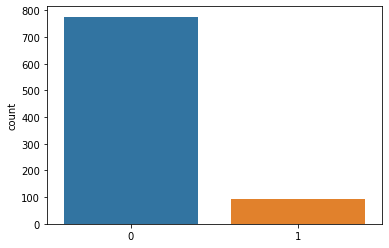

In [ ]:
import seaborn as sns
sns.countplot(prediction)

####**Dphi hyperband Submission :75.51020408163265**

## Bayesian Optimization

2nd class definition

In [130]:
from tensorflow import keras
from tensorflow.keras.layers import (
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    MaxPooling2D
)

INPUT_SHAPE = (224, 224, 1)
NUM_CLASSES = 1
class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        model = Sequential()
        model.add(
            Conv2D(
                filters=64,
                kernel_size=3,
                activation='relu',
                input_shape=self.input_shape
            )
        )
        model.add(
            Conv2D(
                filters=32,
                activation='relu',
                kernel_size=3
            )
        )
        model.add(MaxPooling2D(pool_size=2))
        model.add(
            Dropout(rate=hp.Float(
                'dropout_1',
                min_value=0.0,
                max_value=0.5,
                default=0.25,
                step=0.05,
            ))
        )
        model.add(
            Conv2D(
                filters=32,
                kernel_size=3,
                activation='relu'
            )
        )
        model.add(
            Conv2D(
                filters=hp.Choice(
                    'num_filters',
                    values=[32, 64],
                    default=64,
                ),
                activation='relu',
                kernel_size=3
            )
        )
        model.add(MaxPooling2D(pool_size=2))
        model.add(
            Dropout(rate=hp.Float(
                'dropout_2',
                min_value=0.0,
                max_value=0.5,
                default=0.25,
                step=0.05,
            ))
        )
        model.add(Flatten())
        model.add(
            Dense(
                units=hp.Int(
                    'units',
                    min_value=32,
                    max_value=512,
                    step=32,
                    default=128
                ),
                activation=hp.Choice(
                    'dense_activation',
                    values=['relu', 'tanh', 'sigmoid'],
                    default='relu'
                )
            )
        )
        model.add(
            Dropout(
                rate=hp.Float(
                    'dropout_3',
                    min_value=0.0,
                    max_value=0.5,
                    default=0.25,
                    step=0.05
                )
            )
        )
        model.add(Dense(self.num_classes, activation='sigmoid'))

        model.compile(
            optimizer=keras.optimizers.Adam(
                hp.Float(
                    'learning_rate',
                    min_value=1e-4,
                    max_value=1e-2,
                    sampling='LOG',
                    default=1e-3
                )
            ),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        return model
NUM_CLASSES = 1  
INPUT_SHAPE = (224, 224, 1)  # cifar10 images input shape
hypermodel = CNNHyperModel(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES)

In [133]:
MAX_TRIALS = 20
EXECUTION_PER_TRIAL = 2

In [134]:
!rm -r "/content/drive/MyDrive/HackerEarth/bayesian"

In [135]:
tuner = BayesianOptimization(
    hypermodel,
    objective='val_accuracy',
    max_trials = MAX_TRIALS,
    seed=42,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='/content/drive/MyDrive/HackerEarth/bayesian',
    project_name='out'
)

In [118]:
tuner.search_space_summary()

Search space summary
Default search space size: 11
dropout_1 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
num_filters (Choice)
{'default': 64, 'conditions': [], 'values': [32, 64], 'ordered': True}
dropout_2 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
units (Int)
{'default': 128, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dense_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
dropout_3 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
convolution_1 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 256, 'step': 16, 'sampling': None}
convo

In [ ]:
N_EPOCH_SEARCH = 10
x_train = x_train.reshape(-1,224,224,1)
x_val = x_val.reshape(-1,224,224,1)

tuner.search(x_train, y_train, epochs=N_EPOCH_SEARCH , validation_data=(x_val,y_val))

Trial 16 Complete [00h 03m 52s]
val_accuracy: 0.8836206793785095

Best val_accuracy So Far: 0.9475574791431427
Total elapsed time: 01h 06m 15s

Search: Running Trial #17

Hyperparameter    |Value             |Best Value So Far 
dropout_1         |0                 |0                 
num_filters       |64                |64                
dropout_2         |0                 |0                 
units             |32                |32                
dense_activation  |relu              |relu              
dropout_3         |0                 |0                 
learning_rate     |0.01              |0.0001            

Epoch 1/10
95/95 [==============================] - 11s 119ms/step - loss: 785.8085 - accuracy: 0.7850 - val_loss: 0.3675 - val_accuracy: 0.8836
Epoch 2/10
95/95 [==============================] - 11s 118ms/step - loss: 0.3965 - accuracy: 0.8388 - val_loss: 0.3517 - val_accuracy: 0.8865
Epoch 3/10
95/95 [==============================] - 11s 116ms/step - loss: 0.2992 - 

Max trial =8

In [108]:
# Show a summary of the search
print(tuner.results_summary())

Results summary
Results in /content/drive/MyDrive/HackerEarth/bayesian/out
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
dropout_1: 0.0
num_filters: 32
dropout_2: 0.0
units: 32
dense_activation: relu
dropout_3: 0.0
learning_rate: 0.00010118102562313918
Score: 0.9497126638889313
Trial summary
Hyperparameters:
dropout_1: 0.0
num_filters: 32
dropout_2: 0.5
units: 512
dense_activation: relu
dropout_3: 0.0
learning_rate: 0.0001
Score: 0.9461206793785095
Trial summary
Hyperparameters:
dropout_1: 0.0
num_filters: 32
dropout_2: 0.05
units: 32
dense_activation: relu
dropout_3: 0.0
learning_rate: 0.00010039105667948459
Score: 0.9439655244350433
Trial summary
Hyperparameters:
dropout_1: 0.0
num_filters: 32
dropout_2: 0.0
units: 32
dense_activation: relu
dropout_3: 0.05
learning_rate: 0.0001
convolution_1: 256
convolution_2: 256
convolution_3: 256
convolution_4: 256
Score: 0.9324712455272675
Trial summary
Hyperparameters:
dropout_1: 0.3000000

Max trial 15

In [124]:
print(tuner.results_summary())

Results summary
Results in /content/drive/MyDrive/HackerEarth/bayesian/out
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
dropout_1: 0.0
num_filters: 32
dropout_2: 0.5
units: 512
dense_activation: relu
dropout_3: 0.0
learning_rate: 0.00010000000048754912
Score: 0.9461206793785095
Trial summary
Hyperparameters:
dropout_1: 0.0
num_filters: 32
dropout_2: 0.0
units: 96
dense_activation: relu
dropout_3: 0.15000000000000002
learning_rate: 0.0001
Score: 0.9454023241996765
Trial summary
Hyperparameters:
dropout_1: 0.0
num_filters: 32
dropout_2: 0.0
units: 96
dense_activation: relu
dropout_3: 0.0
learning_rate: 0.00010000001103403744
Score: 0.9432471394538879
Trial summary
Hyperparameters:
dropout_1: 0.0
num_filters: 64
dropout_2: 0.5
units: 32
dense_activation: relu
dropout_3: 0.0
learning_rate: 0.0001
Score: 0.9382183849811554
Trial summary
Hyperparameters:
dropout_1: 0.5
num_filters: 32
dropout_2: 0.0
units: 32
dense_activation: relu
dro

In [109]:
# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
loss, accuracy = best_model.evaluate(x_val, y_val)
print(accuracy)

22/22 [==============================] - 0s 15ms/step - loss: 0.1501 - accuracy: 0.9526
0.9525862336158752


In [125]:
# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
loss, accuracy = best_model.evaluate(x_val, y_val)
print(accuracy)

22/22 [==============================] - 1s 28ms/step - loss: 0.1581 - accuracy: 0.9497
0.9497126340866089


In [126]:
preds = best_model.predict(x_val)

In [127]:
y_pred = []
for i in preds:
  if i > 0.5:
    y_pred.append(1)
  else:
    y_pred.append(0)

max_trails =5

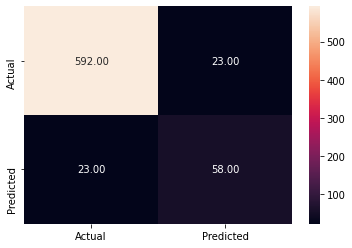

In [68]:
import seaborn as sns
from sklearn.metrics import accuracy_score,confusion_matrix,plot_confusion_matrix
cf = confusion_matrix(y_val,y_pred)
sns.heatmap(cf,annot=True,fmt=".2f",xticklabels=['Actual','Predicted'],yticklabels=['Actual','Predicted'])

With Max_trails = 8

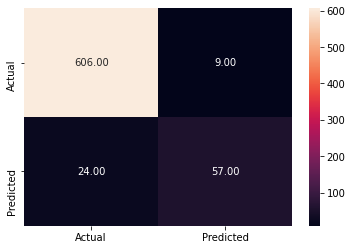

In [112]:
import seaborn as sns
from sklearn.metrics import accuracy_score,confusion_matrix,plot_confusion_matrix
cf = confusion_matrix(y_val,y_pred)
sns.heatmap(cf,annot=True,fmt=".2f",xticklabels=['Actual','Predicted'],yticklabels=['Actual','Predicted'])

Max trail 15

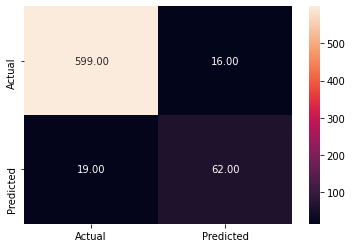

In [128]:
import seaborn as sns
from sklearn.metrics import accuracy_score,confusion_matrix,plot_confusion_matrix
cf = confusion_matrix(y_val,y_pred)
sns.heatmap(cf,annot=True,fmt=".2f",xticklabels=['Actual','Predicted'],yticklabels=['Actual','Predicted'])

# Prediction on Test Images

In [129]:
test_pixel_data = [] # initialize an empty numpy array
image_size = 224 # image size taken is 100 here. one can take other size too
for i in range(len(test_images)):
  img_array = cv2.imread(test_images['filepaths'][i], cv2.IMREAD_GRAYSCALE) # converting the image to gray scale

  new_img_array = cv2.resize(img_array, (image_size, image_size)) # resizing the image array

  test_pixel_data.append(new_img_array)

#
test_pixel_data = np.array(test_pixel_data)
test_pixel_data = test_pixel_data.reshape(-1,224,224,1)
#
print(test_pixel_data.shape)
pred = best_model.predict(test_pixel_data)
prediction = []
for value in pred:
  if value < 0.5:
     prediction.append(0)
  else:
    prediction.append(1)

#
res = pd.DataFrame({'filename': test_images['filename'], 'prediction': prediction}) # prediction is nothing but the final predictions of your model on input features of your new unseen test data
res['prediction'].to_csv("submission_keras_Bayesian1.csv", index = False)

# To download the csv file locally
from google.colab import files
files.download('submission_keras_Bayesian1.csv')

(870, 224, 224, 1)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### **Dphi Submission : 76.28865979381443**  for 1st class definition

#### **Dphi Submission : 	73.58490566037736**  for 2nd class definition